### Lower Elwha River Dam Removal - Vegetation Changes Analysis using Python

Introduction

Location

Methods and Data

<u>Data Citations</u>


In [18]:
# Import libraries for storing and filing data
import os
import pathlib

# Import for finding map 
from osmnx import features as osm
import osmnx as ox

# Import libraries for working with raster data
import hvplot.xarray
import rioxarray as rxr
import xarray as xr

# Import library for working with dataframes
import pandas as pd

# Import library for working with geodataframes, vector data 
import geopandas as gpd

# Import library for plotting
import matplotlib.pyplot as plt

# Import library for making interactive maps and plots 
import holoviews as hv
import hvplot.pandas 

# Import for downloading data
import earthpy
import earthpy.api.appeears as eaapp

import glob


In [6]:
### Define project
project = earthpy.Project("Lower Elwha River Klallam Vegetation Change", dirname = 'lower_elwha')

In [7]:
# Search for Lower Elwha River Klallam Tribal Land
lower_elwha_gdf = ox.geocode_to_gdf('Lower Elwha Klallam Tribe')

# Call the geodataframe
lower_elwha_gdf

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((-123.60319 48.12836, -123.5979...",-123.603192,48.100534,-123.530591,48.151398,350356005,relation,5762804,48.137795,-123.550112,boundary,aboriginal_lands,25,0.066702,aboriginal_lands,Lower Elwha Klallam Tribe,"Lower Elwha Klallam Tribe, Clallam County, Was..."


<Axes: >

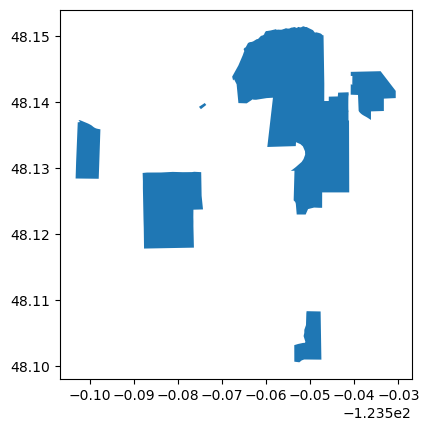

In [8]:
# Plot the polygon to check shape
lower_elwha_gdf.plot()

In [9]:
# Plot the results with web tile images
lower_elwha_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    fill_color=None, line_color='black',
    title='Lower Elwha Klallam Tribe',
    frame_width=500)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [10]:
### Initialize AppeearsDownloader for MODIS NDVI data
### Set parameters
ndvi_downloader = eaapp.AppeearsDownloader(

    ### Name download
    download_key = "lower_elwha_ndvi",

    ### Put data in project (already defined)
    project = project,

    ### Specify the MODIS product
    product = 'MOD13Q1.061',
    layer = '_250m_16_days_NDVI',

    ### Choose a start date and end date
    start_date = "06-01",
    end_date = "09-01",

    ### Recurring means you want those dates over multiple years
    recurring = True,

    ### Specify the range of years you want
    year_range = [2008, 2018],

    ### Specify the polygon you want to get NDVI data for
    polygon = lower_elwha_gdf
)

In the future for a larger dataset, I would submit request using ndvi_downloader.submit() instead and let NASA process the request first... then come back once the dataset has been downloaded. 

In [7]:
# Download data
ndvi_downloader.download_files(cache=True)

No stored credentials found for urs.earthdata.nasa.gov. Please log in.


/opt/conda/lib/python3.11/site-packages/earthpy/api/auth.py:192: UserWarning: Setting credentials not supported for 'netrc' backend.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/earthpy/api/auth.py:196: UserWarning: Failed to store credentials with 'keyring': No recommended backend was available. Install a recommended 3rd party backend package; or, install the keyrings.alt package if you want to use the non-recommended backends. See https://pypi.org/project/keyring for details.
  warnings.warn(


Credentials stored using 'env' backend.


In [11]:
# Get a sorted list of NDVI tif file paths
elwha_ndvi_paths = sorted(
    list(
        project.project_dir.rglob(
            'MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy*.tif'
        )
    )
)

# Display the first and last three files paths to check the pattern
elwha_ndvi_paths[:3], elwha_ndvi_paths[-3:]

([PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2008145000000_aid0001.tif'),
  PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2008161000000_aid0001.tif'),
  PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2008177000000_aid0001.tif')],
 [PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2018209000000_aid0001.tif'),
  PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2018225000000_aid0001.tif'),
  PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2018241000000_aid0001.tif')])

In [12]:
# Calculate the charector number from file path
doy_start = -25
doy_end = -19

# Create empty list
elwha_ndvi_das = []

# Loop through each NDVI image
for elwha_ndvi_path in elwha_ndvi_paths:

    # Get date from file name
    doy = elwha_ndvi_path.name[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open and read dataset and .tif file
    da = rxr.open_rasterio(elwha_ndvi_path, mask_and_scale=True).squeeze()

    # Add date dimension and clean up metadata, da is image
    da = da.assign_coords({'date': date}) # Assign coordinates
    da = da.expand_dims({'date': 1}) # Remove stray values
    da.name = 'NDVI' # Name data array

    # Prepare for concatenation
    elwha_ndvi_das.append(da)

# Return length of new list
len(elwha_ndvi_das)

77

In [13]:
# Combine NDVI images from all dates using xarray
elwha_ndvi_da = xr.combine_by_coords(elwha_ndvi_das, coords=['date'])

# Call the dataarray
elwha_ndvi_da

/tmp/ipykernel_994/3798436614.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  elwha_ndvi_da = xr.combine_by_coords(elwha_ndvi_das, coords=['date'])
/tmp/ipykernel_994/3798436614.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  elwha_ndvi_da = xr.combine_by_coords(elwha_ndvi_das, coords=['date'])


<xarray.Dataset> Size: 278kB
Dimensions:      (date: 77, y: 25, x: 36)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 288B -123.6 -123.6 -123.6 ... -123.5 -123.5 -123.5
  * y            (y) float64 200B 48.15 48.15 48.15 48.14 ... 48.11 48.1 48.1
    spatial_ref  int64 8B 0
  * date         (date) datetime64[ns] 616B 2008-01-14 2008-01-16 ... 2018-01-24
Data variables:
    NDVI         (date, y, x) float32 277kB nan nan nan ... 0.5306 0.5955 0.6321

In [14]:
# Call ndvi_paths to look at data
elwha_ndvi_paths 

[PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2008145000000_aid0001.tif'),
 PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2008161000000_aid0001.tif'),
 PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2008177000000_aid0001.tif'),
 PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2008193000000_aid0001.tif'),
 PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2008209000000_aid0001.tif'),
 PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244/MOD13Q1.061__250m_16_days_NDVI_doy2008225000000_aid0001.tif'),
 PosixPath('/workspaces/data/lower_elwha/lower_elwha_ndvi/MOD13Q1.061_2008138_to_2018244

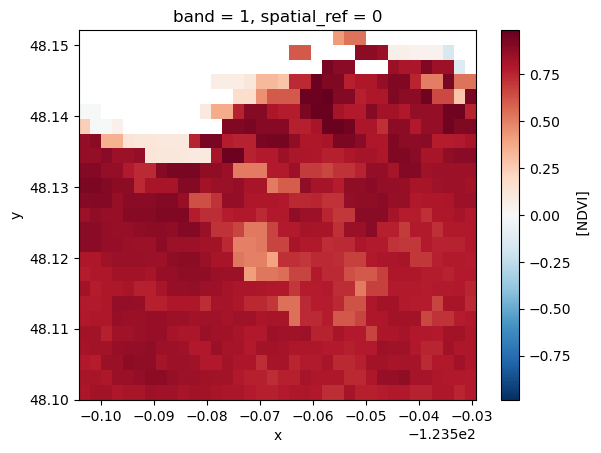

In [15]:
# Plot the first tif image file
rxr.open_rasterio(elwha_ndvi_paths[0], mask_and_scale=True).squeeze().plot()

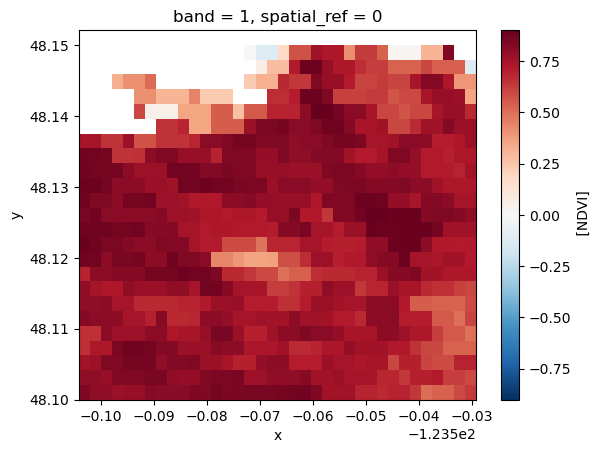

In [16]:
# Plot the last tif image file
rxr.open_rasterio(elwha_ndvi_paths[-1], mask_and_scale=True).squeeze().plot()

Text(0.5, 1.0, 'NDVI - Lower Elwha River Tribe 2018')

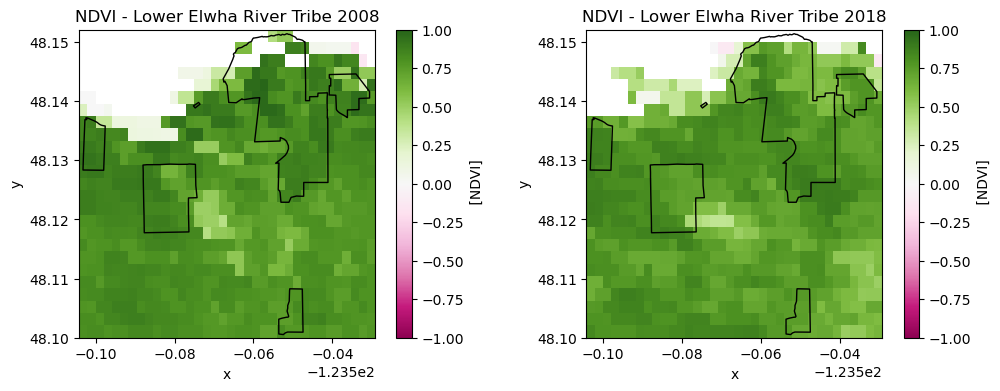

In [19]:
# Create variables for each raster to create side-by-side for comparison
recent_ndvi = rxr.open_rasterio(elwha_ndvi_paths[-1], mask_and_scale=True).squeeze()
old_ndvi = rxr.open_rasterio(elwha_ndvi_paths[0], mask_and_scale=True).squeeze()

# Create and plot side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot first 2001 image on left
old_ndvi.plot(ax=axes[0], cmap=plt.cm.PiYG, vmin=-1, vmax=1)
# Add boundary from AITSN geodataframe
lower_elwha_gdf.plot(ax=axes[0], 
                  edgecolor='black', 
                  facecolor='none', # No fill
                  linewidth=1
)
# Add title
axes[0].set_title("NDVI - Lower Elwha River Tribe 2008")

# Plot most recent 2022 image on right
recent_ndvi.plot(ax=axes[1], cmap=plt.cm.PiYG, vmin=-1, vmax=1)

# Add boundary from AITSN geodataframe
lower_elwha_gdf.plot(ax=axes[1], 
                  edgecolor='black', 
                  facecolor='none', 
                  linewidth=1
)

# Add title
axes[1].set_title("NDVI - Lower Elwha River Tribe 2018")

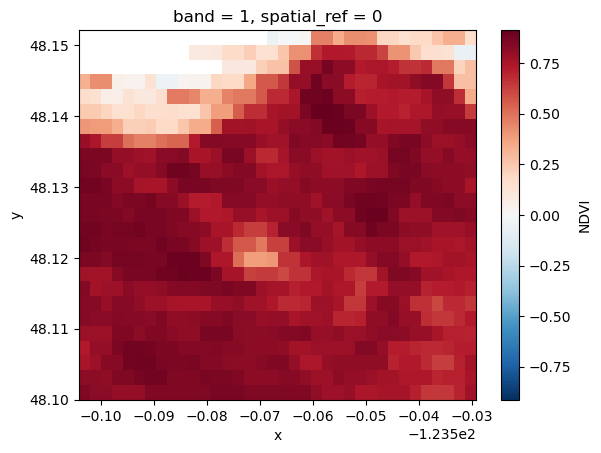

In [23]:
# Calculate the mean of 2001 to 2011 NDVI data
mean_ndvi_2008_2011 = elwha_ndvi_da.sel(date=slice('2008', '2011')).mean('date').NDVI

# Plot the mean to check and view the data 
mean_ndvi_2008_2011.plot()

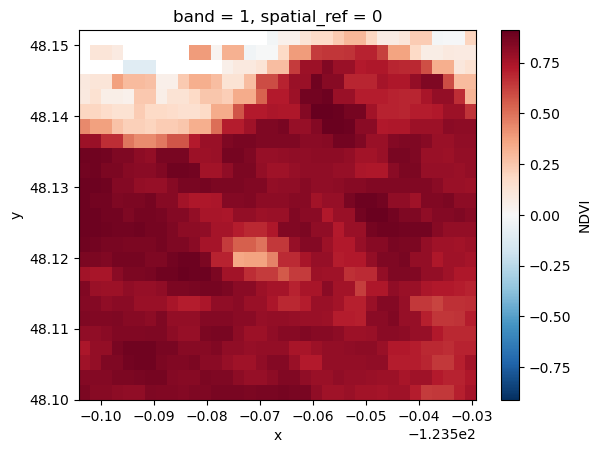

In [24]:
# Calculate the mean of 2012 to 2022 NDVI data
mean_ndvi_2012_2018 = elwha_ndvi_da.sel(date=slice('2012', '2018')).mean('date').NDVI

# Plot the mean to check and view the data 
mean_ndvi_2012_2018.plot()

In [25]:
# Compute the difference in NDVI before and after the return of water rights
ndvi_diff =(
    elwha_ndvi_da
        .sel(date=slice('2012', '2018')) # Date range
            .mean('date') # Calculate mean of date
            .NDVI # Use NDVI data
    - elwha_ndvi_da
        .sel(date=slice('2008', '2011'))
            .mean('date')
            .NDVI
)

# Call the NDVI data
ndvi_diff

<xarray.DataArray 'NDVI' (y: 25, x: 36)> Size: 4kB
array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,  1.59833301e-02,
         5.60999960e-02,  5.60999960e-02,  1.11924991e-01,
        -2.90786684e-01, -2.90786684e-01, -1.02350011e-01,
        -1.17858678e-01, -1.17858678e-01, -2.21497431e-01,
        -1.18631475e-01, -1.18631475e-01, -3.64562497e-02,
         4.85071540e-02,  4.85071540e-02, -2.72341073e-01,
        -3.45161915e-01, -3.45161915e-01,  3.60066593e-02],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,  2.98099995e-01,  2.98099995e-01,
        -7.19999969e-02,  1.52638078e-01,  1.52638078e-01,
        -2.51341641e-01, -1.50311545e-01, -1.50311545e-01,
        -7.40708709e-02, -2.82155871e-02, -2.82155871e-02,
        -2.85843611e-02, -7.72041082e-02, -7.72041082e-02,
...
        -7.21907616e-03, -7.21907616e-03, -3.17695737e-02,
        -2.04396248e-02, -2.04396248e-02, -6.85912371e-03,
         8.62073898e-03,  8.62073898e-03, -1.09332800e-03,
        -1.27083063e-03, -1.27083063e-03, -4.71222401e-03,
        -1.42127872e-02, -1.42127872e-02, -1.85966492e-03,
         1.30656362e-02,  1.30656362e-02,  1.53275728e-02,
         3.14362645e-02,  3.14362645e-02,  2.12392211e-02,
        -1.43459439e-02, -1.43459439e-02, -1.74618363e-02],
       [ 1.01381540e-02,  1.08624101e-02,  1.08624101e-02,
         1.69582367e-02,  4.38064337e-03,  4.38064337e-03,
        -2.25317478e-03, -4.36908007e-03, -4.36908007e-03,
        -7.94035196e-03, -6.61104918e-03, -6.61104918e-03,
         4.34941053e-03,  1.08540058e-03,  1.08540058e-03,
         8.72695446e-03,  1.40606761e-02,  1.40606761e-02,
         2.12342143e-02,  1.94970369e-02,  1.94970369e-02,
         1.22010708e-04, -9.31626558e-03, -9.31626558e-03,
        -4.32300568e-03,  1.68340802e-02,  1.68340802e-02,
         2.18063593e-03,  8.33266973e-03,  8.33266973e-03,
         6.52945042e-03, -9.15354490e-03,  2.64883041e-03,
         2.64883041e-03,  4.13119793e-03, -2.04709172e-02]], dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 288B -123.6 -123.6 -123.6 ... -123.5 -123.5 -123.5
  * y            (y) float64 200B 48.15 48.15 48.15 48.14 ... 48.11 48.1 48.1
    spatial_ref  int64 8B 0

In [26]:
# Plot the difference
(
   ndvi_diff
   .hvplot(
       x='x', 
       y='y',
       title='NDVI Changes at Lower Elwha River Tribe\n(2008-2011) vs.(2012-2018)',
       cmap='PiYG', 
       geo=True)
   *
   lower_elwha_gdf.hvplot(geo=True, fill_color=None, line_color='black')
)

:Overlay
   .Image.I    :Image   [x,y]   (NDVI)
   .Polygons.I :Polygons   [Longitude,Latitude]

In [28]:
# Compute the area outside the Gila River Indian Community
outside_elwha_gdf = (
    gpd.GeoDataFrame(geometry=lower_elwha_gdf.envelope)
    .overlay(lower_elwha_gdf,how='difference')
)

# Call the new geodataframe
outside_elwha_gdf

,geometry
0,"POLYGON ((-123.60319 48.10053, -123.60319 48.1..."


<Axes: >

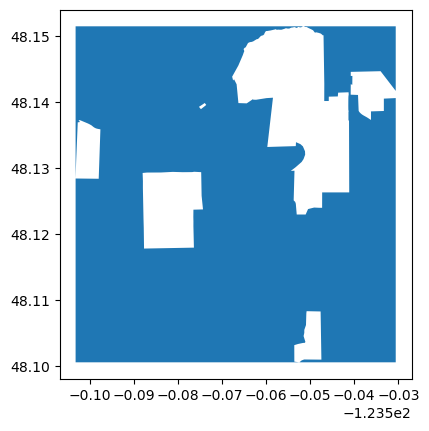

In [29]:
# Plot the new geodataframe 
outside_elwha_gdf.plot()

In [33]:
# Clip data to both inside the boundary
elwha_ndvi_inside = elwha_ndvi_da.rio.clip(lower_elwha_gdf.geometry, from_disk=True)

# Print the data from inside the boundary
print(elwha_ndvi_inside)

# Clip data to both inside the boundary
elwha_ndvi_outside = elwha_ndvi_da.rio.clip(outside_elwha_gdf.geometry, from_disk=True)

# Print the data from inside the boundary
print(elwha_ndvi_outside)

<xarray.Dataset> Size: 263kB
Dimensions:      (x: 34, y: 25, date: 77)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 272B -123.6 -123.6 -123.6 ... -123.5 -123.5 -123.5
  * y            (y) float64 200B 48.15 48.15 48.15 48.14 ... 48.11 48.1 48.1
  * date         (date) datetime64[ns] 616B 2008-01-14 2008-01-16 ... 2018-01-24
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (date, y, x) float32 262kB nan nan nan nan ... nan nan nan nan
<xarray.Dataset> Size: 271kB
Dimensions:      (x: 35, y: 25, date: 77)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 280B -123.6 -123.6 -123.6 ... -123.5 -123.5 -123.5
  * y            (y) float64 200B 48.15 48.15 48.15 48.14 ... 48.11 48.1 48.1
  * date         (date) datetime64[ns] 616B 2008-01-14 2008-01-16 ... 2018-01-24
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (date, y, x) float32 270kB nan nan nan ... 0.5306 0.5306 0.5955


In [34]:
# Create new dataframe for inside and compute mean annual July NDVI
july_ndvi_elwha_inside_df = (elwha_ndvi_inside
                       .groupby(elwha_ndvi_inside.date.dt.year)
                       .mean(...)
                       .NDVI.to_dataframe()
)

# Print the outside mean annual July NDVI
print('Mean NDVI inside Lower Elwha Tribe', july_ndvi_elwha_inside_df.head())

# Create new dataframe for outside and compute mean annual July NDVI
july_ndvi_elwha_outside_df = (elwha_ndvi_outside
                       .groupby(elwha_ndvi_outside.date.dt.year)
                       .mean(...)
                       .NDVI.to_dataframe()
)

# Print the outside mean annual July NDVI
print('Mean NDVI outisde Lower Elwha Tribe', july_ndvi_elwha_outside_df.head())

Mean NDVI inside Lower Elwha Tribe       band  spatial_ref      NDVI
year                             
2008     1            0  0.800276
2009     1            0  0.810800
2010     1            0  0.764509
2011     1            0  0.814493
2012     1            0  0.802320
Mean NDVI outisde Lower Elwha Tribe       band  spatial_ref      NDVI
year                             
2008     1            0  0.758740
2009     1            0  0.758149
2010     1            0  0.722739
2011     1            0  0.783135
2012     1            0  0.774991


In [35]:
# Join the inside and outside GRIC dataframe
july_ndvi_elwha_df = (july_ndvi_elwha_inside_df[['NDVI']]
                .join(july_ndvi_elwha_outside_df[['NDVI']], 
                      lsuffix=' Inside Lower Elwha', # Rename left column
                      rsuffix=' Outside Lower Elwha') # Rename right column
) 

# Call dataframe
july_ndvi_elwha_df

,NDVI Inside Lower Elwha,NDVI Outside Lower Elwha
year,,
2008,0.800276,0.758740
2009,0.810800,0.758149
2010,0.764509,0.722739
2011,0.814493,0.783135
2012,0.802320,0.774991
2013,0.784052,0.756371
2014,0.783939,0.759958
2015,0.790558,0.752608
2016,0.777087,0.748260


In [36]:
# Plot the mean NDVI iside and outside GRIC boundary
july_ndvi_elwha_df.hvplot(title='Mean July NDVI Inside and Outside Lower Elwha')

:NdOverlay   [Variable]
   :Curve   [year]   (value)

In [37]:
# Calculate the difference inside & outside the boundary / create column
july_ndvi_elwha_df['Difference'] = (july_ndvi_elwha_df['NDVI Inside Lower Elwha'] 
                                - july_ndvi_elwha_df['NDVI Outside Lower Elwha'])

# Call the new dataframe with new difference column
july_ndvi_elwha_df

,NDVI Inside Lower Elwha,NDVI Outside Lower Elwha,Difference
year,,,
2008,0.800276,0.758740,0.041536
2009,0.810800,0.758149,0.052651
2010,0.764509,0.722739,0.041769
2011,0.814493,0.783135,0.031358
2012,0.802320,0.774991,0.027328
2013,0.784052,0.756371,0.027681
2014,0.783939,0.759958,0.023981
2015,0.790558,0.752608,0.037950
2016,0.777087,0.748260,0.028827


In [38]:
# Plot the difference in NDVI inside and ouside GRIC
july_ndvi_elwha_df.Difference.hvplot(
    title='Difference in Mean July NDVI inside & outside Lower Elwha Tribe')

:Curve   [year]   (Difference)